In [1]:
import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Step 1 : Importing the Dataset

In [2]:
import pandas as pd

df = pd.read_csv("data/train.csv")

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df['num_labels'] = df[label_cols].sum(axis=1)
print(df[label_cols].sum())


toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


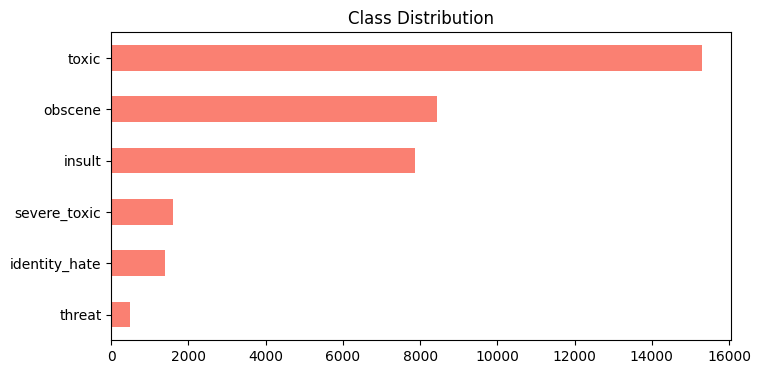

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
df[label_cols].sum().sort_values().plot(kind='barh', color='salmon')
plt.title("Class Distribution")
plt.show()


In [4]:
df['num_labels'] = df[label_cols].sum(axis=1)
print(df['num_labels'].value_counts())


num_labels
0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: count, dtype: int64


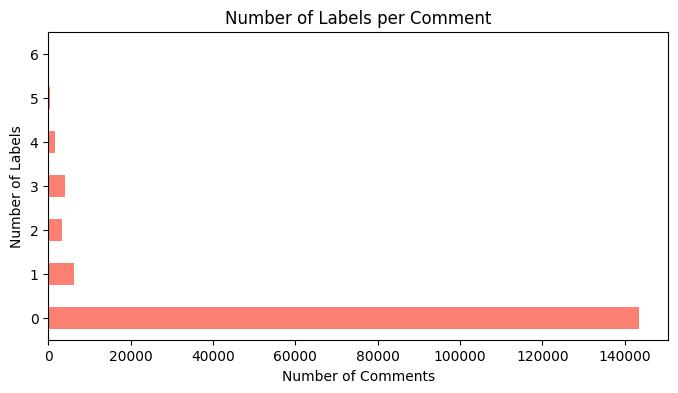

In [5]:
import matplotlib.pyplot as plt

# Compute class distribution
label_counts = df['num_labels'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8,4))
label_counts.plot(kind='barh', color='salmon')
plt.title("Number of Labels per Comment")
plt.xlabel("Number of Comments")
plt.ylabel("Number of Labels")
plt.show()


## Step 2 : Preperocessing the Dataset

In [6]:
df_toxic = df[df[label_cols].sum(axis=1) > 0]   # all toxic rows
df_nontoxic = df[df[label_cols].sum(axis=1) == 0].sample(n=5000, random_state=42)  # balance it a bit
df_sample = pd.concat([df_toxic, df_nontoxic])


In [7]:
df_sample

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,num_labels
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,4
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,1
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,1
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,4
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,3
...,...,...,...,...,...,...,...,...,...
93501,f9fe9c58f6b36026,and because it is influencing this article,0,0,0,0,0,0,0
19372,3324f728edf22e89,I'm happy to create Ceschi discography and mov...,0,0,0,0,0,0,0
36802,62486c1da44f53e9,"""\nHe just vandalized your page again. He shou...",0,0,0,0,0,0,0
126039,a221843e788ee7a6,Thanks for the acknowledgment! I went bold on ...,0,0,0,0,0,0,0


In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import pandas as pd
import ssl
from functools import partial
from typing import Optional

def secure_nltk_download():
    """Safely download required NLTK data with SSL verification handling"""
    try:
        # First try with default SSL context
        nltk.download('stopwords', quiet=True)
        nltk.download('punkt', quiet=True)
        nltk.download('wordnet', quiet=True)
    except (ssl.SSLError, Exception):
        try:
            # Fallback with unverified context if SSL fails
            _create_unverified_https_context = ssl._create_unverified_context
            ssl._create_default_https_context = _create_unverified_https_context
            nltk.download('stopwords', quiet=True)
            nltk.download('punkt', quiet=True)
            nltk.download('wordnet', quiet=True)
        except Exception as e:
            raise RuntimeError(f"Failed to download NLTK data: {str(e)}")

def initialize_resources() -> tuple[set, WordNetLemmatizer]:
    """Initialize and cache NLP resources"""
    secure_nltk_download()
    return set(stopwords.words('english')), WordNetLemmatizer()

# Initialize resources once (cached for performance)
STOPWORDS, LEMMATIZER = initialize_resources()
URL_PATTERN = re.compile(r"https?://\S+|www\.\S+")
NON_ALPHABETIC = re.compile(r"[^a-zA-Z\s]")

def preprocess_text(
    text: str,
    stopwords: Optional[set] = None,
    lemmatizer: Optional[WordNetLemmatizer] = None,
    extra_clean_patterns: Optional[list] = None
) -> str:
    """
    Preprocess text with comprehensive cleaning and normalization
    
    Args:
        text: Input text to process
        stopwords: Custom stopwords set (defaults to English stopwords)
        lemmatizer: Custom lemmatizer instance
        extra_clean_patterns: Additional regex patterns to clean
        
    Returns:
        Cleaned and normalized text string
    """
    if not isinstance(text, str):
        return ""
    
    # Use cached resources if not provided
    stopwords = stopwords or STOPWORDS
    lemmatizer = lemmatizer or LEMMATIZER
    
    # Text cleaning pipeline
    text = text.lower().strip()
    text = URL_PATTERN.sub("", text)
    text = NON_ALPHABETIC.sub("", text)
    
    # Apply any additional custom cleaning patterns
    if extra_clean_patterns:
        for pattern in extra_clean_patterns:
            text = pattern.sub("", text)
    
    # Tokenization and normalization
    tokens = word_tokenize(text)
    tokens = [
        lemmatizer.lemmatize(token) 
        for token in tokens 
        if token not in stopwords and len(token) > 1
    ]
    
    return " ".join(tokens)

# Optimized pandas application using partial
preprocess_column = partial(
    preprocess_text,
    stopwords=STOPWORDS,
    lemmatizer=LEMMATIZER
)

    
# Apply preprocessing
df_sample['clean_text'] = df_sample['comment_text'].apply(preprocess_column)
print(df_sample[['comment_text', 'clean_text']])

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>


                                             comment_text  \
6            COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK   
12      Hey... what is it..\n@ | talk .\nWhat is it......   
16      Bye! \n\nDon't look, come or think of comming ...   
42      You are gay or antisemmitian? \n\nArchangel WH...   
43               FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!   
...                                                   ...   
93501          and because it is influencing this article   
19372   I'm happy to create Ceschi discography and mov...   
36802   "\nHe just vandalized your page again. He shou...   
126039  Thanks for the acknowledgment! I went bold on ...   
157721  You also forgot the most important one of all:...   

                                               clean_text  
6                             cocksucker piss around work  
12      hey talk exclusive group wp talibanswho good d...  
16           bye dont look come think comming back tosser  
42      gay antisemmitian a

In [9]:
df_sample.to_csv("data/processed.csv")

## Step 3 : Feature Extraction

In [10]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


# Feature extraction
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # Consider both unigrams and bigrams
    min_df=5,            # Ignore terms that appear in fewer than 5 documents
    max_df=0.7          # Ignore terms that appear in more than 70% of documents
)

# Transform text data
X = tfidf.fit_transform(df_sample['clean_text'])

# Get labels - convert to numpy array if not already
y = df_sample[label_cols].to_numpy() if isinstance(df_sample[label_cols], pd.DataFrame) else df_sample[label_cols].values

# Train-test split with stratification (maintaining class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2,
    random_state=42,
    stratify=y if len(label_cols) == 1 else None  # Stratify for single-label
)

print(f"Training shape: {X_train.shape}, Test shape: {X_test.shape}")

Training shape: (16980, 5000), Test shape: (4245, 5000)


## Step 4 : Running Baseline Models

In [11]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logreg = OneVsRestClassifier(LogisticRegression(class_weight="balanced"))
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(classification_report(y_test, y_pred, target_names=label_cols))


               precision    recall  f1-score   support

        toxic       0.93      0.84      0.88      3047
 severe_toxic       0.32      0.76      0.45       319
      obscene       0.85      0.77      0.81      1713
       threat       0.32      0.67      0.44        87
       insult       0.72      0.75      0.74      1581
identity_hate       0.36      0.71      0.48       284

    micro avg       0.75      0.79      0.77      7031
    macro avg       0.58      0.75      0.63      7031
 weighted avg       0.80      0.79      0.79      7031
  samples avg       0.51      0.57      0.51      7031



/Users/fadizouabi/Projects/Toxic_Comment_Classifier/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fadizouabi/Projects/Toxic_Comment_Classifier/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fadizouabi/Projects/Toxic_Comment_Classifier/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control 

In [12]:
from sklearn.metrics import accuracy_score
report = classification_report(y_test, y_pred, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], output_dict=True, zero_division=0)
model_evaluation = {'Logistic Regression' : {'F1_Score':report['weighted avg']['f1-score'],
                                            'Accuracy': accuracy_score(y_test,y_pred),
                                            'Recall':report['weighted avg']['recall'],
                                            'Precision':report['weighted avg']['precision']}}

In [13]:
model_evaluation

{'Logistic Regression': {'F1_Score': 0.7892890067273924,
  'Accuracy': 0.45441696113074204,
  'Recall': 0.7914948087043094,
  'Precision': 0.8044706938744793}}

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import XGBoost

In [19]:
rf = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf, target_names=label_cols))

Random Forest Performance:
               precision    recall  f1-score   support

        toxic       0.84      0.93      0.88      3047
 severe_toxic       0.43      0.09      0.15       319
      obscene       0.86      0.77      0.81      1713
       threat       0.53      0.11      0.19        87
       insult       0.73      0.68      0.70      1581
identity_hate       0.66      0.25      0.37       284

    micro avg       0.81      0.76      0.78      7031
    macro avg       0.67      0.47      0.52      7031
 weighted avg       0.79      0.76      0.76      7031
  samples avg       0.62      0.59      0.58      7031



/Users/fadizouabi/Projects/Toxic_Comment_Classifier/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fadizouabi/Projects/Toxic_Comment_Classifier/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fadizouabi/Projects/Toxic_Comment_Classifier/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control 

In [20]:
report = classification_report(y_test, y_pred_rf, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], output_dict=True, zero_division=0)
random_forest = {'Random Forest' : {'F1_Score':report['weighted avg']['f1-score'],
                                            'Accuracy': accuracy_score(y_test,y_pred_rf),
                                            'Recall':report['weighted avg']['recall'],
                                            'Precision':report['weighted avg']['precision']}}

In [21]:
model_evaluation['Random Forest'] = random_forest['Random Forest']
model_evaluation

{'Logistic Regression': {'F1_Score': 0.7892890067273924,
  'Accuracy': 0.45441696113074204,
  'Recall': 0.7914948087043094,
  'Precision': 0.8044706938744793},
 'Random Forest': {'F1_Score': 0.763174173704878,
  'Accuracy': 0.48645465253239106,
  'Recall': 0.7582136253733466,
  'Precision': 0.7918854427293557}}

In [26]:
from xgboost import XGBClassifier
xgb = MultiOutputClassifier(XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1))
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb, target_names=label_cols))


/Users/fadizouabi/Projects/Toxic_Comment_Classifier/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:33:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/fadizouabi/Projects/Toxic_Comment_Classifier/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:33:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/fadizouabi/Projects/Toxic_Comment_Classifier/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:33:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/fadizouabi/Projects/Toxic_Comment_Classifier/venv/lib/python3.11/site-packages/xgboost/training.py:183: User

XGBoost Performance:
               precision    recall  f1-score   support

        toxic       0.85      0.94      0.89      3047
 severe_toxic       0.52      0.23      0.32       319
      obscene       0.88      0.77      0.82      1713
       threat       0.53      0.22      0.31        87
       insult       0.76      0.67      0.71      1581
identity_hate       0.61      0.36      0.45       284

    micro avg       0.82      0.77      0.80      7031
    macro avg       0.69      0.53      0.58      7031
 weighted avg       0.81      0.77      0.78      7031
  samples avg       0.63      0.60      0.59      7031



/Users/fadizouabi/Projects/Toxic_Comment_Classifier/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fadizouabi/Projects/Toxic_Comment_Classifier/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fadizouabi/Projects/Toxic_Comment_Classifier/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control 

In [27]:
report = classification_report(y_test, y_pred_xgb, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], output_dict=True, zero_division=0)
xg_boost = {'XG Boost' : {'F1_Score':report['weighted avg']['f1-score'],
                                            'Accuracy': accuracy_score(y_test,y_pred_xgb),
                                            'Recall':report['weighted avg']['recall'],
                                            'Precision':report['weighted avg']['precision']}}

In [28]:
model_evaluation['XG Boost'] = xg_boost['XG Boost']
model_evaluation

{'Logistic Regression': {'F1_Score': 0.7892890067273924,
  'Accuracy': 0.45441696113074204,
  'Recall': 0.7914948087043094,
  'Precision': 0.8044706938744793},
 'Random Forest': {'F1_Score': 0.763174173704878,
  'Accuracy': 0.48645465253239106,
  'Recall': 0.7582136253733466,
  'Precision': 0.7918854427293557},
 'XG Boost': {'F1_Score': 0.7814279375996718,
  'Accuracy': 0.4977620730270907,
  'Recall': 0.7722941260133693,
  'Precision': 0.8052680577774649}}

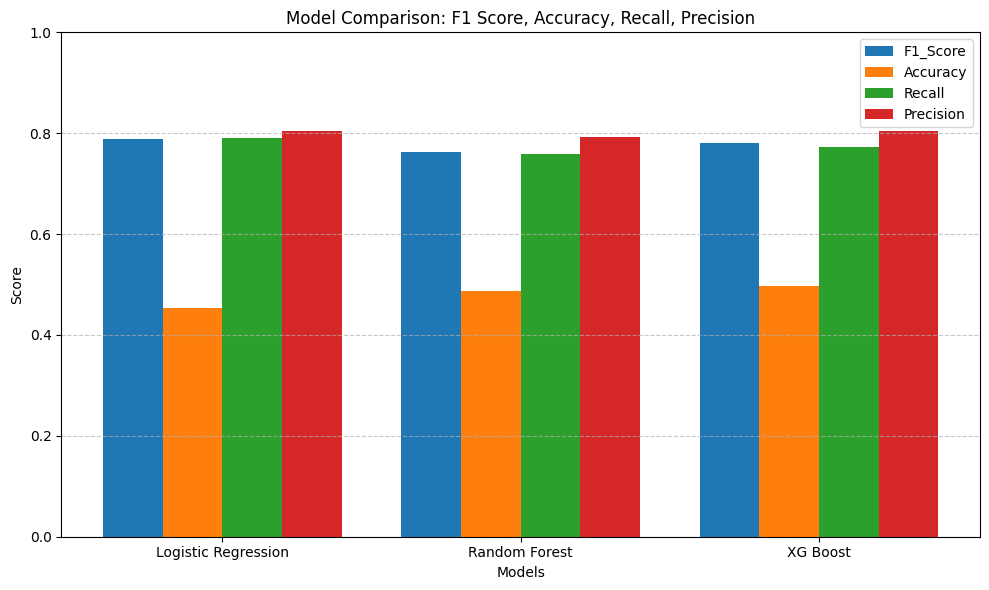

In [29]:
import matplotlib.pyplot as plt
import numpy as np


# Extract metric names and model names
metrics = ['F1_Score', 'Accuracy', 'Recall', 'Precision']
models = list(model_evaluation.keys())

# Convert to a 2D list for plotting
metric_values = [[model_evaluation[model][metric] for model in models] for metric in metrics]

# Plot settings
x = np.arange(len(models))  # label locations
width = 0.2  # width of the bars

plt.figure(figsize=(10, 6))

# Plot each metric as a group of bars
for i, metric in enumerate(metrics):
    plt.bar(x + i * width, metric_values[i], width=width, label=metric)

# Add labels and formatting
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Comparison: F1 Score, Accuracy, Recall, Precision')
plt.xticks(x + width * 1.5, models)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()


## Step 5 : Perfroming Some Analytics 

### 1) Confounding Bias

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

vectorizer = CountVectorizer(max_features=5000)
X_counts = vectorizer.fit_transform(df_sample['clean_text'])
words = np.array(vectorizer.get_feature_names_out())

def top_words_for_class(class_index):
    mask = (df_sample[label_cols[class_index]] == 1).values  # Convert to NumPy array
    toxic_words = X_counts[mask].sum(axis=0)
    sorted_indices = np.argsort(np.asarray(toxic_words).flatten())[::-1]
    return words[sorted_indices[:10]]

for i, label in enumerate(label_cols):
    print(f"Top words in '{label}': {top_words_for_class(i)}")


Top words in 'toxic': ['fuck' 'suck' 'shit' 'like' 'dont' 'nigger' 'wikipedia' 'fucking' 'go'
 'hate']
Top words in 'severe_toxic': ['fuck' 'suck' 'shit' 'as' 'faggot' 'fucking' 'go' 'die' 'cunt' 'nigger']
Top words in 'obscene': ['fuck' 'suck' 'shit' 'fucking' 'nigger' 'as' 'go' 'faggot' 'cunt' 'dont']
Top words in 'threat': ['die' 'as' 'kill' 'going' 'block' 'must' 'wale' 'jim' 'supertrll' 'dont']
Top words in 'insult': ['fuck' 'suck' 'nigger' 'fucking' 'faggot' 'go' 'fat' 'as' 'cunt' 'shit']
Top words in 'identity_hate': ['nigger' 'jew' 'fat' 'gay' 'fuck' 'die' 'faggot' 'fucking' 'nigga' 'suck']


### 2) Performing Heteroscedaticity

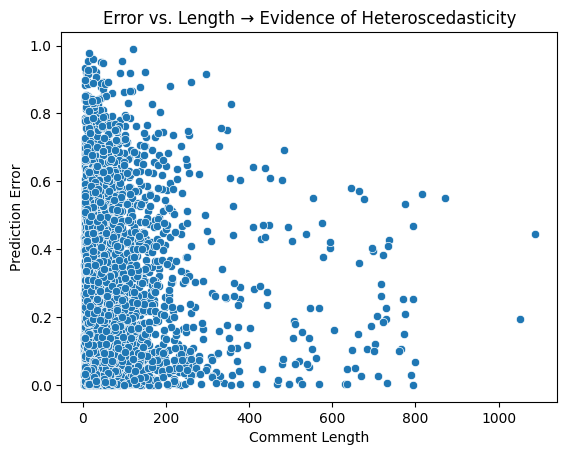

In [31]:
from sklearn.linear_model import LogisticRegressionCV
import seaborn as sns
import matplotlib.pyplot as plt

lengths = df['comment_text'].apply(lambda x: len(x.split()))
probs = logreg.predict_proba(X_test)  # shape: [samples, labels]
errors = np.abs(probs[:, 0] - y_test[:, 0])  # example: 'toxic' label

sns.scatterplot(x=lengths[:len(errors)], y=errors)
plt.xlabel("Comment Length")
plt.ylabel("Prediction Error")
plt.title("Error vs. Length → Evidence of Heteroscedasticity")
plt.show()

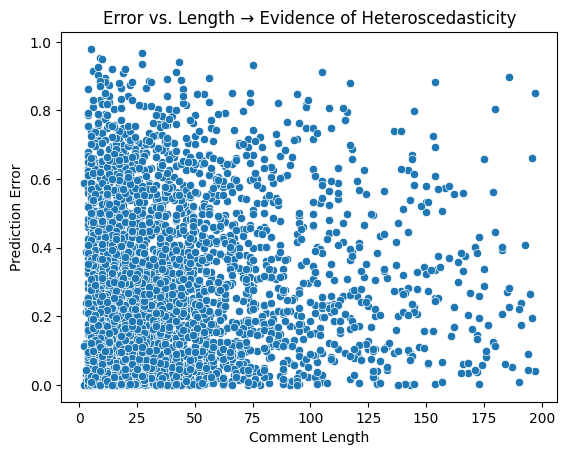

In [32]:
from sklearn.model_selection import train_test_split

# Step 1: Split the raw data
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df_sample['comment_text'], df_sample[label_cols], test_size=0.2, random_state=42
)

# Step 2: Vectorize test set
X_test = tfidf.transform(X_test_text)

# Step 3: Predict
probs = logreg.predict_proba(X_test)
errors = np.abs(probs[:, 0] - y_test.iloc[:, 0])  # 'toxic' class

# Step 4: Compute lengths for matching test comments
lengths = X_test_text.apply(lambda x: len(x.split()))

mask = lengths < 200
# Step 5: Plot — now perfectly aligned
sns.scatterplot(x=lengths[mask], y=errors[mask])
plt.xlabel("Comment Length")
plt.ylabel("Prediction Error")
plt.title("Error vs. Length → Evidence of Heteroscedasticity")
plt.show()


## Step 6 : Balancing the Dataset

### 1) Load a Pretrained Paraphrasing Model (T5) for balancing the dataset

In [34]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

# T5-based paraphraser
paraphrase_model = AutoModelForSeq2SeqLM.from_pretrained("Vamsi/T5_Paraphrase_Paws")
paraphrase_tokenizer = AutoTokenizer.from_pretrained("Vamsi/T5_Paraphrase_Paws")

# Pipeline for easy generation
paraphraser = pipeline("text2text-generation", model=paraphrase_model, tokenizer=paraphrase_tokenizer)

/Users/fadizouabi/Projects/Toxic_Comment_Classifier/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Device set to use mps:0


### 2) Selecting the rare classes

In [35]:
# Focus on rare classes
rare_df = df_sample[df_sample[["threat", "severe_toxic", "identity_hate"]].sum(axis=1) > 0]
samples_to_augment = rare_df.sample(n=500, random_state=42)

def truncate_text(text, max_tokens=450):
    tokens = text.split()
    return ' '.join(tokens[:max_tokens])

samples_to_augment["comment_text"] = samples_to_augment["comment_text"].apply(truncate_text)


### 3) Generate Phrases for each comment

In [36]:
augmented_texts = []

for text in samples_to_augment["comment_text"]:
    input_text = f"paraphrase: {text} </s>"
    # Generate 3 paraphrases per sample to boost minority class count
    result = paraphraser(
    input_text,
    max_length=256,
    num_return_sequences=3,     
    num_beams=10,
    do_sample=True,
    top_k=120,
    top_p=0.95
    )
    paraphrased = result[0]['generated_text']
    augmented_texts.append(paraphrased)


Token indices sequence length is longer than the specified maximum sequence length for this model (1127 > 512). Running this sequence through the model will result in indexing errors


In [37]:
augmented_texts

["I'm a jackass, I'm a jackass, I'm a jackass. I'm a jackass, I'm a jackass. Oh oh oh, I'm a jackass 69.156.179.180",
 'fuck 62.158.73.165 62.158.73.165 62.158.73.165 62.158.73.165 62.158.73.165 62.158.73.165 62.158.73.165 62.158.73.165 62.158.73.165 62.158.73.165 62.158.73.165 62.158.73.165',
 'DISGUSTING You sick Eastern Euros, blaming a raped, burned girl!!! SICK SICK!!',
 'If you want to argue that he was a racial Jew, do it in the appropriate discussion page, under a new, appropriate heading, Mr. Censor Tyrant .',
 'Edit Request Hello guys FUCK U pieces of shit I HATE WIKIPEDIA doNATE! ZmINecraft is way better than ur stupid social networking site called fricken wikipedia Face book is a better social networking site than you ***********',
 'Fuck u gogo dogo and cluebot!',
 'Russian bitches, hands off the truth, get out of Ukraine, get out of American Wikipedia! 188.231.192.218 Ukrainian soldier.',
 'That was gay like me....absolutely....uninformative, gay like me im gay mutha fuck

### 5) Combine with original data

In [38]:
augmented_df = samples_to_augment.copy()
augmented_df["comment_text"] = augmented_texts

# Combine original + augmented
balanced_df = pd.concat([df_sample, augmented_df], ignore_index=True)

# Shuffle
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save if needed
balanced_df.to_csv("balanced_textual_toxic.csv", index=False)

In [39]:
balanced_df.shape

(21725, 10)

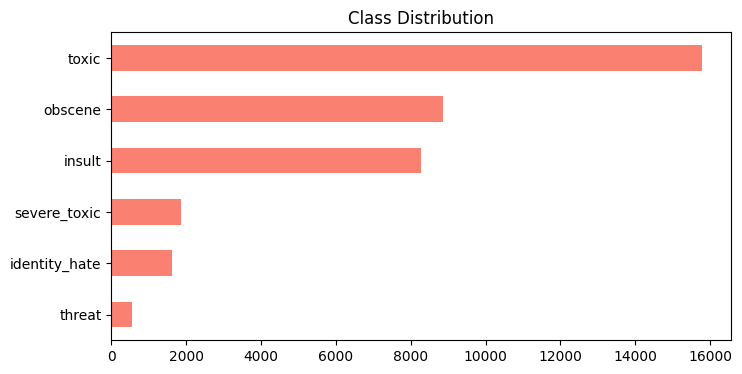

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
balanced_df[label_cols].sum().sort_values().plot(kind='barh', color='salmon')
plt.title("Class Distribution")
plt.show()

In [41]:
balanced_df['num_labels'] = balanced_df[label_cols].sum(axis=1)
print(balanced_df[label_cols].sum())

toxic            15773
severe_toxic      1876
obscene           8858
threat             553
insult            8284
identity_hate     1635
dtype: int64
